Epoch 0, Loss: 1.179133
Epoch 200, Loss: 0.030112
Epoch 400, Loss: 0.042390
Epoch 600, Loss: 0.025238
Epoch 800, Loss: 0.037369
Epoch 1000, Loss: 0.020582
Epoch 1200, Loss: 0.032957
Epoch 1400, Loss: 0.025317
Epoch 1600, Loss: 0.054768
Epoch 1800, Loss: 0.016468


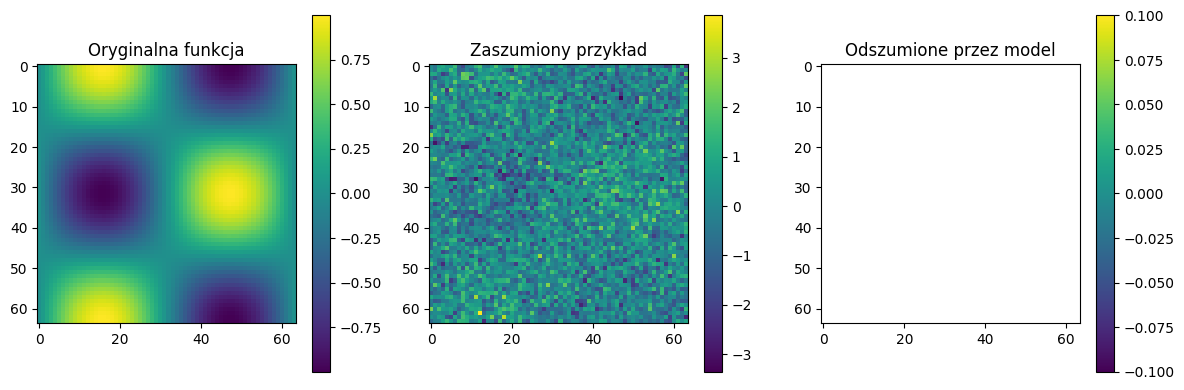

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Sinusoidal time embedding
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, embedding_dim):
        super().__init__()
        self.embedding_dim = embedding_dim

    def forward(self, timesteps):
        device = timesteps.device
        half_dim = self.embedding_dim // 2
        exponents = torch.exp(
            torch.arange(half_dim, device=device) * -(np.log(10000) / (half_dim - 1))
        )
        embeddings = timesteps[:, None] * exponents[None, :]
        embeddings = torch.cat([torch.sin(embeddings), torch.cos(embeddings)], dim=-1)
        return embeddings

# UNet blocks
class UNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_channels)
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU()
        )

    def forward(self, x, t_emb):
        h = self.block(x)
        t = self.time_mlp(t_emb).view(-1, h.shape[1], 1, 1)
        return h + t

class UNet(nn.Module):
    def __init__(self, time_emb_dim=128):
        super().__init__()
        self.time_embedding = SinusoidalPositionEmbeddings(time_emb_dim)

        self.enc1 = UNetBlock(1, 64, time_emb_dim)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = UNetBlock(64, 128, time_emb_dim)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = UNetBlock(128, 256, time_emb_dim)
        self.pool3 = nn.MaxPool2d(2)
        self.bottleneck = UNetBlock(256, 512, time_emb_dim)

        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = UNetBlock(512, 256, time_emb_dim)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = UNetBlock(256, 128, time_emb_dim)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = UNetBlock(128, 64, time_emb_dim)

        self.final = nn.Conv2d(64, 1, 1)

    def forward(self, x, t):
        t_emb = self.time_embedding(t)
        e1 = self.enc1(x, t_emb)
        e2 = self.enc2(self.pool1(e1), t_emb)
        e3 = self.enc3(self.pool2(e2), t_emb)
        b = self.bottleneck(self.pool3(e3), t_emb)
        d3 = self.up3(b)
        d3 = self.dec3(torch.cat([d3, e3], dim=1), t_emb)
        d2 = self.up2(d3)
        d2 = self.dec2(torch.cat([d2, e2], dim=1), t_emb)
        d1 = self.up1(d2)
        d1 = self.dec1(torch.cat([d1, e1], dim=1), t_emb)
        return self.final(d1)

# Data generation
def generate_2d_data(grid_size=64):
    x = np.linspace(0, 2 * np.pi, grid_size)
    y = np.linspace(0, 2 * np.pi, grid_size)
    X, Y = np.meshgrid(x, y)
    Z = np.sin(X) * np.cos(Y)
    return Z.astype(np.float32)

def add_noise(x, t, noise):
    return x * torch.sqrt(1 - t) + noise * torch.sqrt(t)

# Training
def train_diffusion(model, clean_data, n_steps=1000, epochs=2000):
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()
    clean_tensor = torch.tensor(clean_data).unsqueeze(0).unsqueeze(0)

    for epoch in range(epochs):
        model.train()
        t = torch.rand((1,), dtype=torch.float32)
        t_norm = t.clone().detach()
        noise = torch.randn_like(clean_tensor)
        noised = add_noise(clean_tensor, t_norm, noise)
        output = model(noised, t_norm)
        loss = loss_fn(output, noise)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch % 200 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}")
    return model

# Sampling
@torch.no_grad()
def sample(model, shape, steps=100):
    x = torch.randn(shape)
    for i in reversed(range(1, steps+1)):
        t = torch.tensor([i / steps], dtype=torch.float32)
        predicted_noise = model(x, t)
        x = (x - predicted_noise * torch.sqrt(t)) / torch.sqrt(1 - t)
    return x

# Run
grid_size = 64
clean = generate_2d_data(grid_size)
model = UNet()
trained_model = train_diffusion(model, clean, epochs=2000)

denoised = sample(trained_model, shape=(1, 1, grid_size, grid_size), steps=100)
denoised_np = denoised.squeeze().detach().numpy()

# Visualization
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Oryginalna funkcja")
plt.imshow(clean, cmap='viridis')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("Zaszumiony przykład")
noisy_example = add_noise(torch.tensor(clean).unsqueeze(0).unsqueeze(0), torch.tensor(0.8), torch.randn(1,1,grid_size,grid_size))
plt.imshow(noisy_example.squeeze().numpy(), cmap='viridis')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title("Odszumione przez model")
plt.imshow(denoised_np, cmap='viridis')
plt.colorbar()
plt.tight_layout()
plt.show()
